# Configuration du notebook

In [3]:
# Data analysis libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud

# Image processing library
from PIL import Image

# Text processing libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mzmae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Chargement des données
X_train = pd.read_csv("./../data/X_train_update.csv", index_col=0)
y_train = pd.read_csv("./../data/Y_train_CVw08PX.csv", index_col=0)
X_test = pd.read_csv("./../data/X_test_update.csv", index_col=0)

In [16]:
def data_info(df):
    df.info()
    print("\n")
    display(df.head())
    print("\n")


# Exploration des données

Les premières choses à comprendre concernant les données :

- X_train contient toutes les données que nous avons pour l'entraînement ET les tests : elles sont associées aux valeurs de y_train.
- X_test contient uniquement les données à classifier avec notre modèle afin d’être évalué dans le cadre du challenge Rakuten.
- Il en va de même pour les images.

## Description de X_train

In [18]:
data_info(X_train, "X_train")

#### Nan values in X_train ####

print("NaN values in X_train")
X_train_nan = X_train.isna().sum()
print(X_train_nan)
print("\n")

print("Nan values ratio in X_train", X_train_nan / len(X_train))

#### Unique values in train variables ####

print("Unique value numbers in train variables :", end = "\n\n")
print(X_train.nunique(), end = "\n\n")

# Less unique values in Designation than productid and imageid -> Duplicates with different id ?

#### Duplicated values in train variables ####

print("# of duplicates in designation :", round(X_train.duplicated(subset = ["designation"]).sum()/len(X_train["designation"])*100, 2), "%")
print("# of duplicates in productid :", X_train.duplicated(subset = ["productid"]).sum())
print("# of duplicates in imageid :", X_train.duplicated(subset = ["imageid"]).sum())

# Duplicates of products with different productid and imageid

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB




,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786




NaN values in X_train
designation        0
description    29800
productid          0
imageid            0
dtype: int64


Nan values ratio in X_train designation    0.000000
description    0.350935
productid      0.000000
imageid        0.000000
dtype: float64
Unique value numbers in train variables :

designation    82265
description    47506
productid      84916
imageid        84916
dtype: int64

# of duplicates in designation : 3.12 %
# of duplicates in productid : 0
# of duplicates in imageid : 0


Conformément à la description des données, seule la description est optionnelle, on remarque que le jeu de données est complet et que c'est la seule variable avec des valeurs nulles.

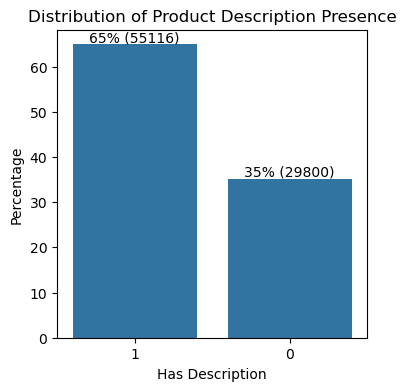

In [101]:
# Dichotomisation de la présence de description dans X_train
X_train['has_description'] = X_train['description'].notna().astype(int)

abs_values = X_train['has_description'].value_counts(ascending=False)
rel_values = X_train['has_description'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}% ({p[0]})' for p in zip(abs_values, rel_values)]

# Affichage de la distribution de has_description
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=X_train, x='has_description', order=X_train['has_description'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Description Presence')
plt.xlabel('Has Description')
plt.ylabel('Percentage')
plt.show()

Il y a plus de produits avec une description (65 %) que de produits sans description (35%) malgré le caractère optionnel de la description. On peut supposer que cela est dû à l'importance de la description de l'article pour favoriser sa vente en plus de sa catégorisation. En effet, la description fournit d'autres éléments discriminant pour un produit dans le cadre de la recherche via un moteur parmi de nombreux produits.

## Description de y_train

In [ ]:
data_info(y_train, "y_train")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB




,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


In [ ]:
# Nombre de valeurs uniques dans y_train
print("Unique values in y_train")
print(y_train.nunique())

Unique values in y_train
prdtypecode    27
dtype: int64


Il existe 27 classes de produits distinctes dans le jeu de données d'apprentissage.

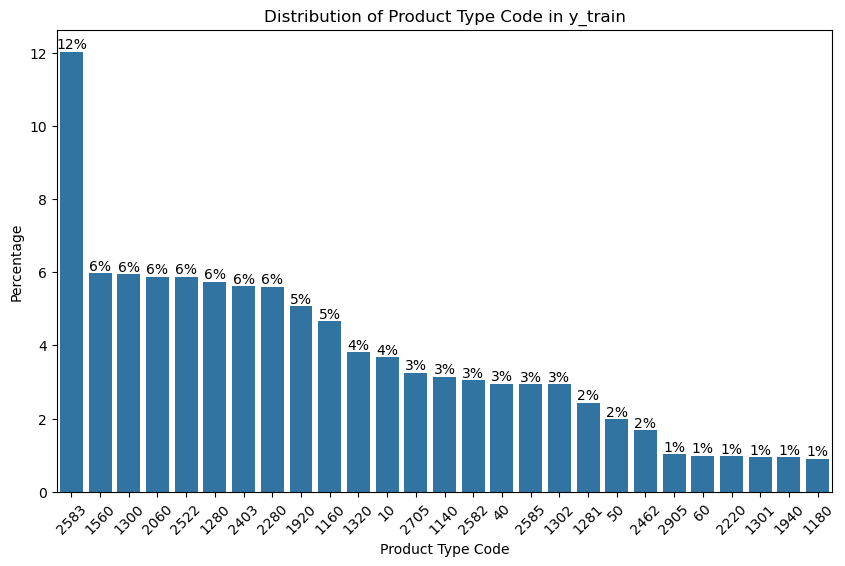

In [ ]:
abs_values = y_train['prdtypecode'].value_counts(ascending=False)
rel_values = y_train['prdtypecode'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}%' for p in zip(abs_values, rel_values)]

# Histogramme de la distribution des codes de type de produit dans y_train
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=y_train, x='prdtypecode', order=y_train['prdtypecode'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Type Code in y_train')
plt.xlabel('Product Type Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

Le jeu de données n'est pas équilibré :
- la classe 2583 est plus représentée que les autres avec 12% du jeu de données
- les classes 1560, 1300, 2060, 2522, 1280, 2403, 2280 suivent ensuite avec 6% chacune seulement
- les classes les moins représentées (2905, 60, 2220, 1301, 1940, 1180) représentent quant à elles 1% chacune

## Analyse des variables disponibles

### Analyse croisée entre la présence de 'description' du produit et la catégorie du produit


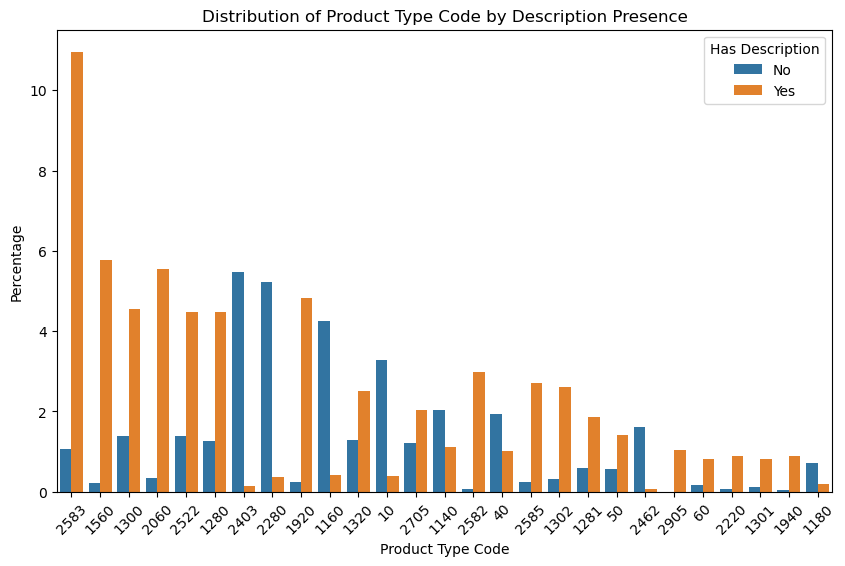

In [ ]:
# Affichage de la distribution des codes de type de produit en fonction de la présence de description
plt.figure(figsize=(10, 6))
sns.countplot(data=y_train, x='prdtypecode', hue=X_train['has_description'], order=y_train['prdtypecode'].value_counts().index, stat='percent')
plt.title('Distribution of Product Type Code by Description Presence')
plt.xlabel('Product Type Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Has Description', loc='upper right', labels=['No', 'Yes'])
plt.show()

La répartition de produits avec ou sans description n'est pas homogène entre les catégories de produit par rapport au ratio moyen du jeu de données (65% avec et 35% sans description).
Certains produits comme 2403 contiennent majoritairement des produits non décrits alors que d'autres comme 1560 contiennent majoritairement des produits décrits.

### Analyse de la longueur de la variable 'designation'


Text(0.5, 0, 'Designation Length')

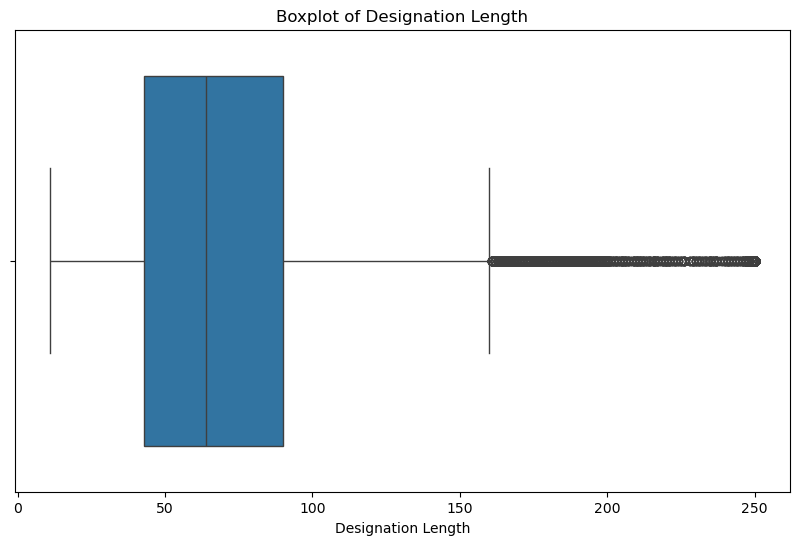

In [ ]:
X_train['designation_length'] = X_train['designation'].str.len()

# Boxplot de la longueur de la variable 'designation'
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, x='designation_length')

plt.title('Boxplot of Designation Length')
plt.xlabel('Designation Length')

In [ ]:
X_train['designation_length'].describe()

count    84916.000000
mean        70.163303
std         36.793383
min         11.000000
25%         43.000000
50%         64.000000
75%         90.000000
max        250.000000
Name: designation_length, dtype: float64

On observe que la longueur de designation est très variable avec un min de 11 caractères et un max de 250 caractères.
Sa longueur moyenne est de 70 caractères et la médiane se situe à 64 caractères.
D'après le boxplot, il existe beaucoup d'outliers au dela de 160 caractères.

### Analyse croisée de la catégorie et de la longueur de la 'designation'

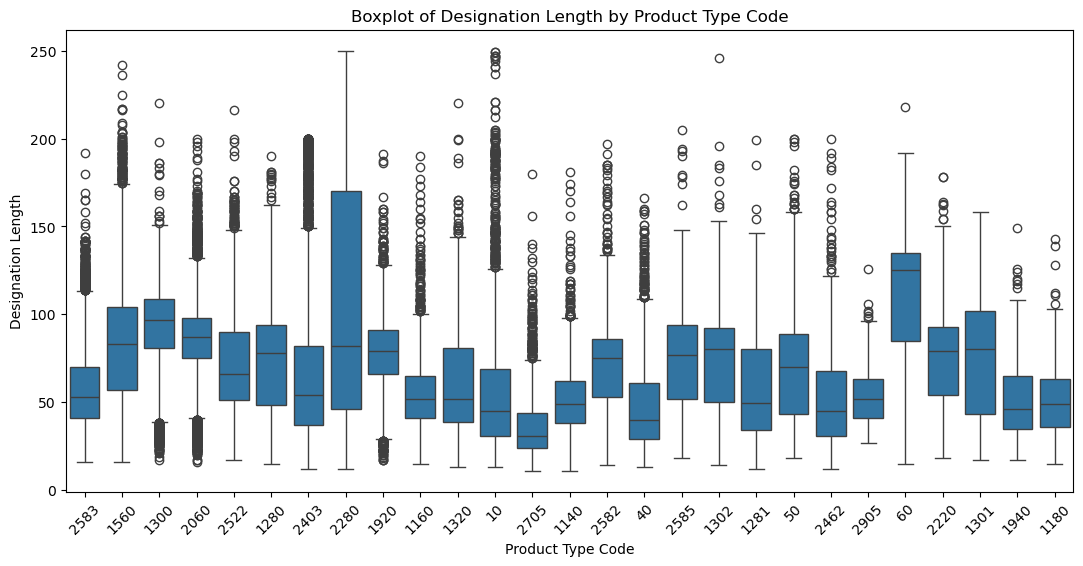

In [ ]:
# Boxplot de la longueur de la variable 'designation' par catégorie de produit
plt.figure(figsize=(13, 6))
sns.boxplot(x=y_train['prdtypecode'], y=X_train['designation_length'], order=y_train['prdtypecode'].value_counts().index)
plt.title('Boxplot of Designation Length by Product Type Code')
plt.xlabel('Product Type Code')
plt.ylabel('Designation Length')
plt.xticks(rotation=45)
plt.show()

La distribution de la longueur de Designation par catégorie de produit n'est pas homogène.

### Analyse des duplicats de 'designation'

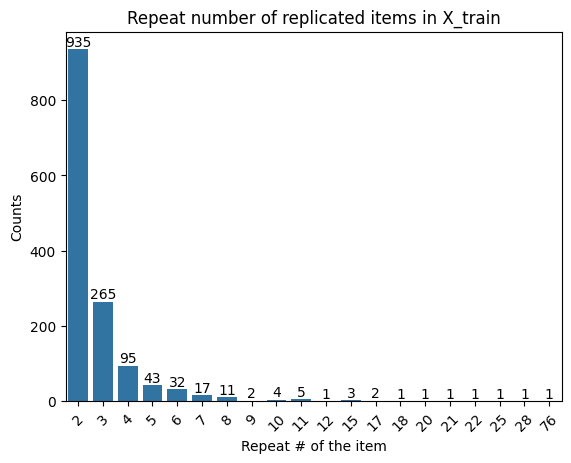

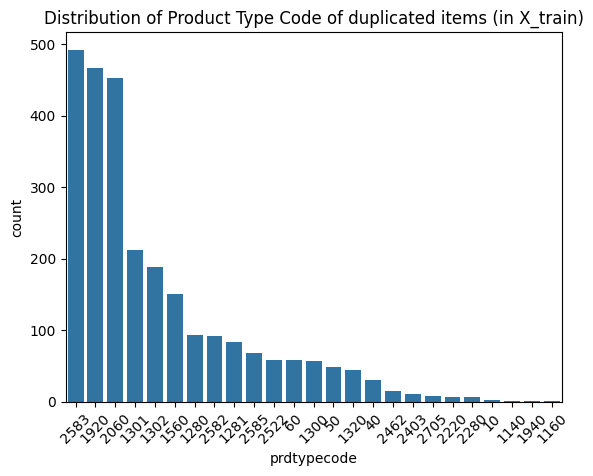

In [ ]:
#### Duplicated values frequencies

counts = X_train["designation"].value_counts().reset_index()
counts.columns = ["designation", "repeat"]

repeats = counts['repeat'].value_counts().sort_index().reset_index()

repeats = repeats.iloc[1:]

ax = sns.barplot(data = repeats, x = 'repeat', y = 'count')
ax.bar_label(container = ax.containers[0],  fmt='%d')
plt.xticks(rotation = 45)
plt.xlabel("Repeat # of the item")
plt.ylabel("Counts")
plt.title("Repeat number of replicated items in X_train")
plt.show()


#### Duplicated values' categories

y_duplicated = y_train[X_train.duplicated(subset = ["designation"]) == True]

sns.countplot(data = y_duplicated, x = 'prdtypecode', order = y_duplicated['prdtypecode'].value_counts().index)
plt.xticks(rotation = 45)
plt.title("Distribution of Product Type Code of duplicated items (in X_train)")
plt.show()

On observe de récurrents lignes de 'Designation' avec des fréquences qui varient de 2 à 76 instances: 935 articles se répètent 2 fois, 1 article 76 fois
On observe ces répétitions de Designation dans des catégories différentes

### Analyse de la longueur de la variable 'description'


Text(0.5, 0, 'Description Length')

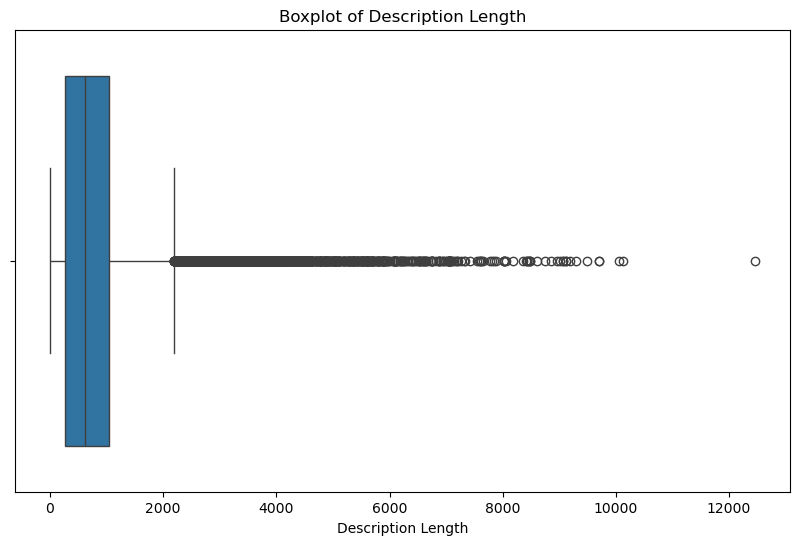

In [ ]:
X_train['description_length'] = X_train['description'].str.len()

# Boxplot de la longueur de la variable 'descpription'
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, x='description_length')

plt.title('Boxplot of Description Length')
plt.xlabel('Description Length')

In [ ]:
X_train['description_length'].describe()

count    55116.000000
mean       808.171692
std        805.462153
min          1.000000
25%        259.000000
50%        626.000000
75%       1034.000000
max      12451.000000
Name: description_length, dtype: float64

On observe que la longueur de description est très variable avec un min de 1 caractères et un max de 12451 caractères.
Sa longueur moyenne est de 808 caractères et la médiane se situe à 626 caractères.
D'après le boxplot, il existe beaucoup d'outliers au dela de 2000 caractères.

### Analyse de la 'description' par catégorie de produit

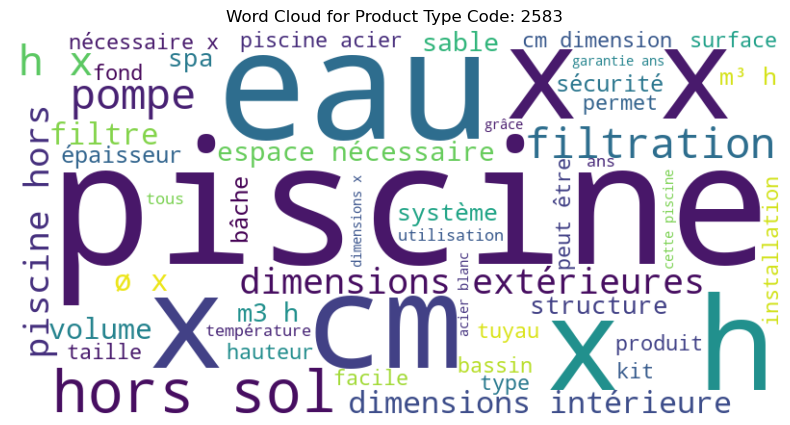

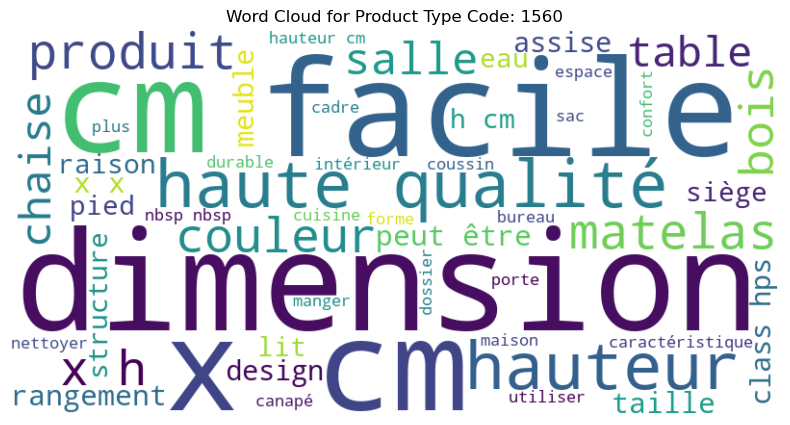

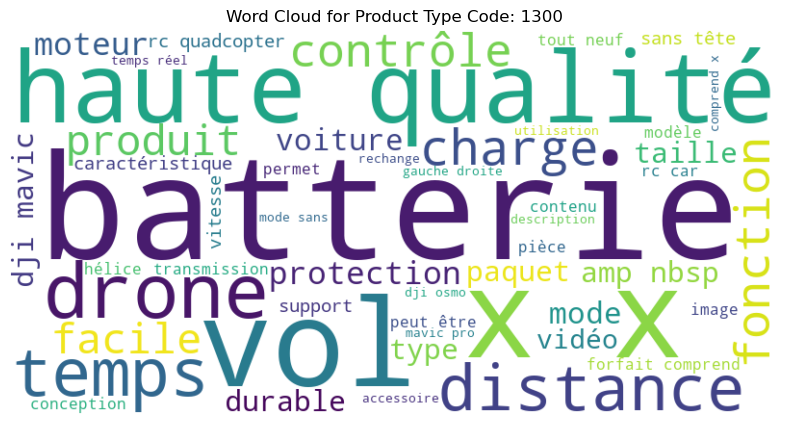

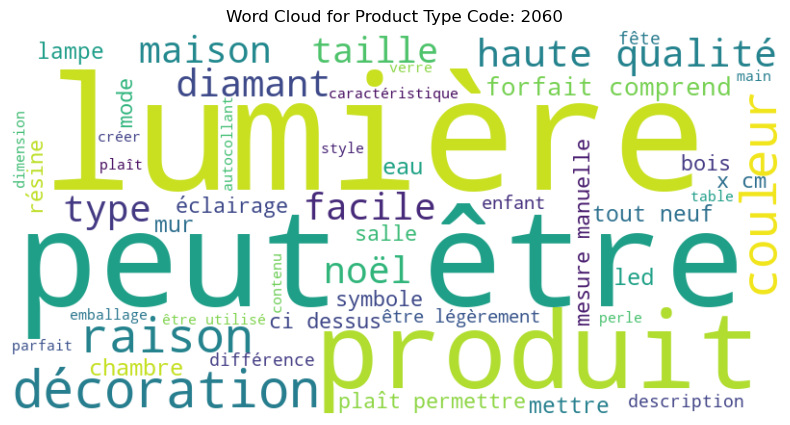

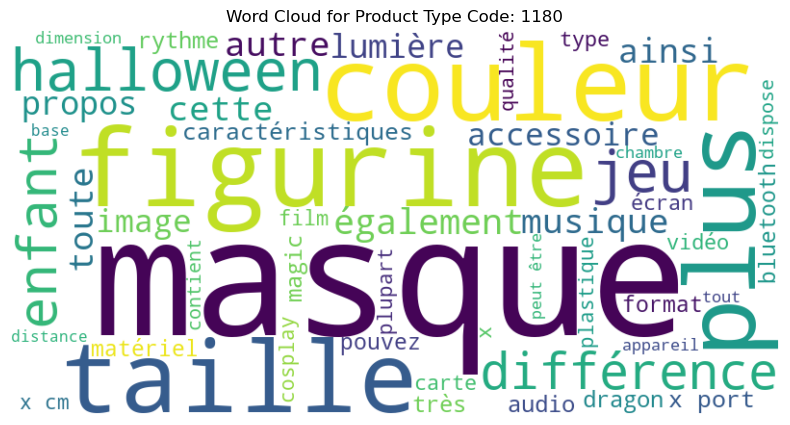

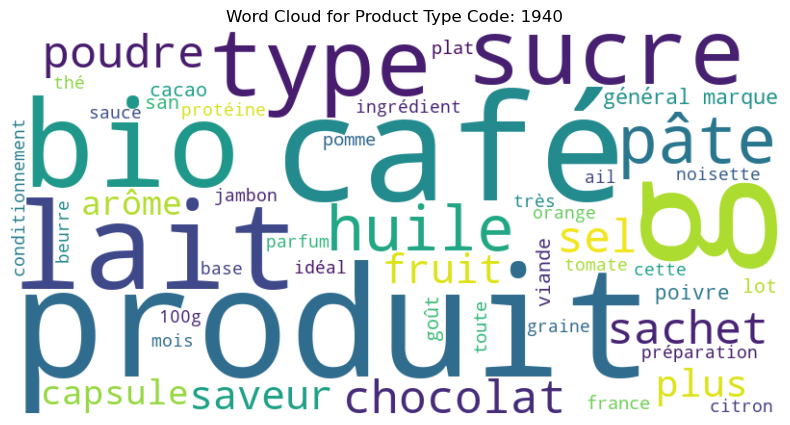

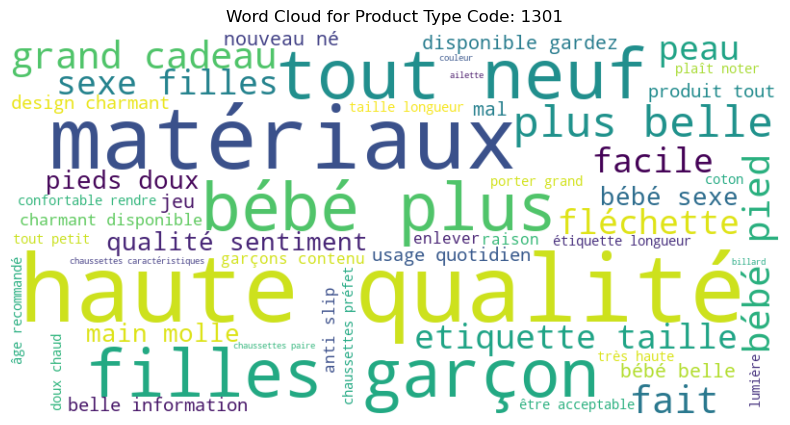

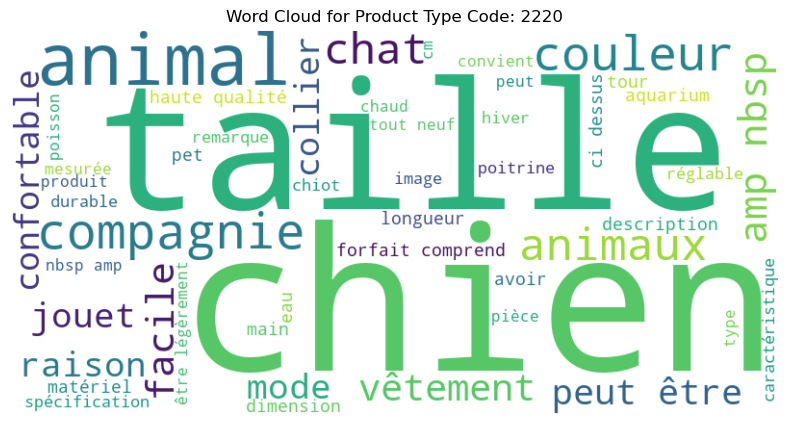

In [ ]:
html_stopwords = ['br', 'p', 'div', 'span', 'b', 'i', 'li', 'ul', 'strong', 'em']
final_stopwords = stopwords.words('english') + stopwords.words('french') + html_stopwords

# Récupération des 4 catégories de produits avec le plus et le moins de descriptions pour comparaison
most_descriptions = y_train['prdtypecode'].value_counts().nlargest(4).index.tolist()
least_descriptions = y_train['prdtypecode'].value_counts().nsmallest(4).index.tolist()

# Concaténation de toutes les descriptions de chaque product code pour la création du nuage de mots
for code in most_descriptions + least_descriptions:
    text = ' '.join(X_train.loc[y_train['prdtypecode'] == code, 'description'].dropna().tolist())

    # Nettoyage du texte (apostrophes, ponctuation, etc.)
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Création du nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, stopwords = final_stopwords).generate(text)
    
    # Affichage du nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Product Type Code: {code}')
    plt.show()

Les 4 worclouds des catégories de produits avec le plus de descriptions et les 4 wordclouds de celles avec le moins de descriptions mettent clairement en avant certains termes plus que d'autres.

Cela nous permet d'identifier la catégorie de produit d'une manière sémantique à la lecture des termes mis en exergue : on pourra étudier cette intuition en faisant du deep learning ou encore du NLP pour classifier les catégories.

Sachant que nous avons principalement des données non structurées pour la classification (du texte parfois optionnel et des images), cette approche semble la plus efficace.

## Analyse des images

Chemins des dossiers d’images:

In [5]:
# Paths
image_train_path = "./../data/images/image_train/"
image_test_path = "./../data/images/image_test/"

### Affichage des images

Fonctions utiles pour l’affichage :

In [6]:
# Find a picture path from its imageid and its productid
def image_path(imageid, productid, split="train"):
    if split == "train":
        path = image_train_path
    elif split == "test":
        path = image_test_path
    else:
        raise Exception("split must be train or test.")

    image_path = path + "image_" + str(imageid) + "_product_" + str(productid) + ".jpg"
    return image_path


# Display an image from its path or an image objetc
def display_image(image, print_dim=False):
    if isinstance(image, str):
        img = mpimg.imread(image)
    else:
        img = image

    if print_dim:
        print(f"Image dimensions: {img.shape[0]}x{img.shape[1]} pixels")

    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return


# Display an image from its imageid and its productid
def display_image_df(imageid, productid, split="train", print_dim=False):
    display_image(image_path(imageid, productid, split), print_dim)
    return


# Display an image from a textual row
def display_image_from_row(index_or_row_number, split="train", is_index=True, print_dim=False):
    """
    Display a picture from index (is_index must be True) or
    row number (is_index must be False) of the considered split.
    print_dim allows to print the dimensions of the image.
    """
    if split == "train":
        df = X_train
    elif split == "test":
        df = X_test
    else:
        raise Exception("split must be train or test.")
        
    if is_index:
        display_image_df(df.loc[index_or_row_number, "imageid"], df.loc[index_or_row_number, "productid"], split, print_dim)
    else:
        display_image_df(df.iloc[index_or_row_number, 3], df.iloc[index_or_row_number, 2], split, print_dim)
    return



Quelques exemples d'images avec les fonctions utiles vues précédemment.

Image dimensions: 500x500 pixels


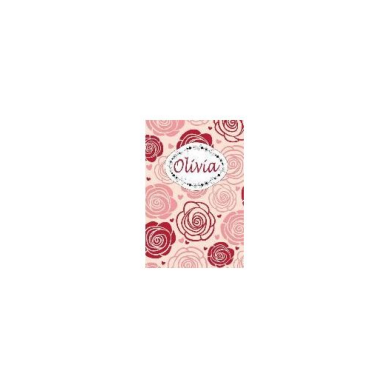

In [7]:
display_image_df(1263597046, 3804725264, "train", print_dim=True)

Image dimensions: 500x500 pixels


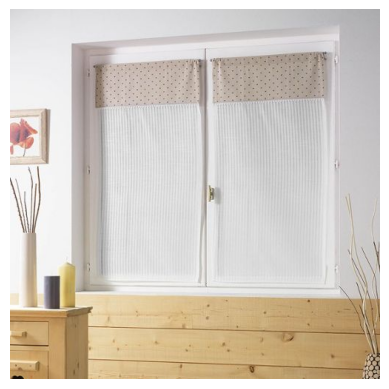

In [8]:
display_image_df(X_train.loc[13, "imageid"], X_train.loc[13, "productid"], "train", print_dim=True)

Image dimensions: 500x500 pixels


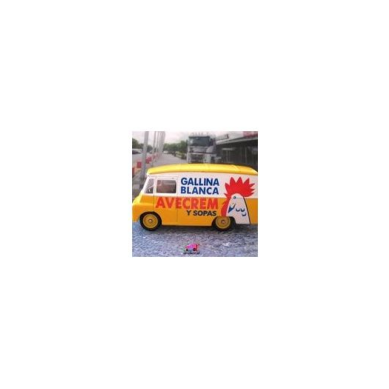

In [9]:
display_image_from_row(15, "test", is_index=False, print_dim=True)

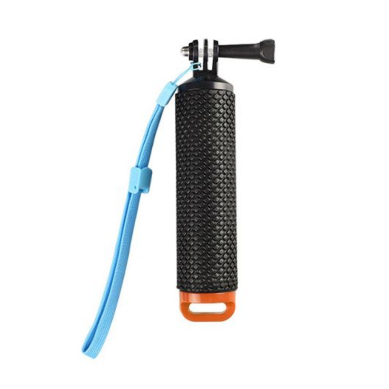

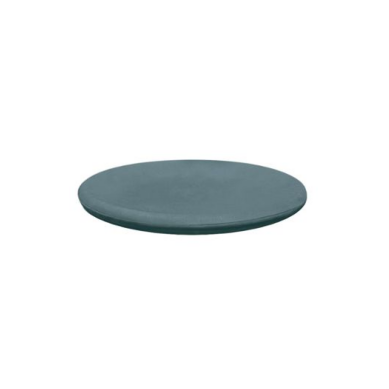

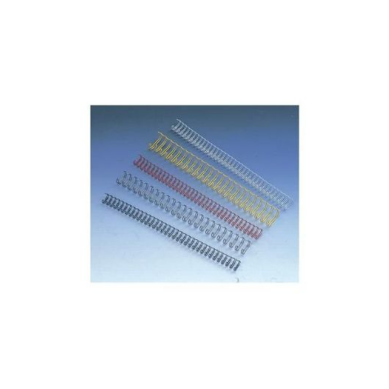

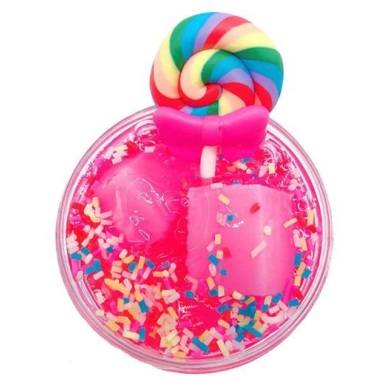

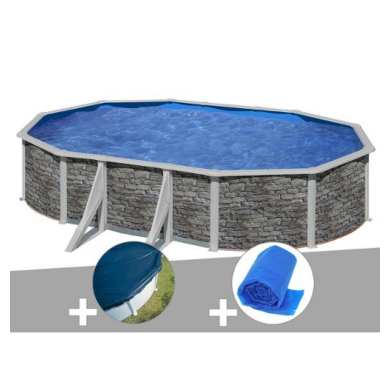

In [ ]:
### Random images read with Matplotlib ###
for i in np.random.choice(np.arange(0, len(X_train)), size=5):
    display_image_from_row(i, "train", is_index=False)

On remarque que toutes les images semblent être de la même dimension 500x500 pixels et en couleur. Cependant leurs dimensions utiles sont différentes: la différence est comblée par des bords blancs.

Dans un premier temps, nous vérifierons l'unicité du format des images, puis nous nous intéresserons aux dimensions utiles.

### Vérification du format

Associons à chaque produit le path de l'image qui lui correspond.

In [10]:
X_train["imagepath"] = X_train.apply(lambda row: image_path(row["imageid"], row["productid"], "train"), axis=1)
X_test["imagepath"] = X_test.apply(lambda row: image_path(row["imageid"], row["productid"], "test"), axis=1)

Le dataset traincontient autant que d'images que de produits (84916). On pose alors l'hypothèse très probable que chaque produit a bien une image associée, même si elle est vide (entièrement blanche, ce qu'on testera plus tard), ce qui correspondrait à une valeur nulle.

Les chargements ou traitements d'image étant assez lourds, nous décidons de prendre seulement un échantillon de 1000 images aléatoires (mais reproductible) pour notre première analyse, et nous gardons les produits associées en textuel de côté.

In [11]:
X_train_sample = X_train.sample(n=1000, random_state=42)

X_img_sample = X_train_sample["imagepath"]
X_img_sample.head()

36138    ./../data/images/image_train/image_1100082580_...
68630    ./../data/images/image_train/image_1139624392_...
36172    ./../data/images/image_train/image_1271697301_...
9830     ./../data/images/image_train/image_1313204688_...
28422    ./../data/images/image_train/image_518749844_p...
Name: imagepath, dtype: object

On l'enrichit avec d'autres informations.

In [12]:
def shape_from_path(image_path):
    img = mpimg.imread(image_path)
    return img.shape

In [13]:
X_img_sample = pd.concat([
    X_img_sample.rename("image_path"),
    X_img_sample.apply(shape_from_path).rename("image_shape")
], axis=1)

In [17]:
data_info(X_img_sample)

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 36138 to 65534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   1000 non-null   object
 1   image_shape  1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB




,image_path,image_shape
36138,./../data/images/image_train/image_1100082580_...,"(500, 500, 3)"
68630,./../data/images/image_train/image_1139624392_...,"(500, 500, 3)"
36172,./../data/images/image_train/image_1271697301_...,"(500, 500, 3)"
9830,./../data/images/image_train/image_1313204688_...,"(500, 500, 3)"
28422,./../data/images/image_train/image_518749844_p...,"(500, 500, 3)"


Vérifions que dans le dataset (au moins dans l'échantillon), toutes les images sont au même format.

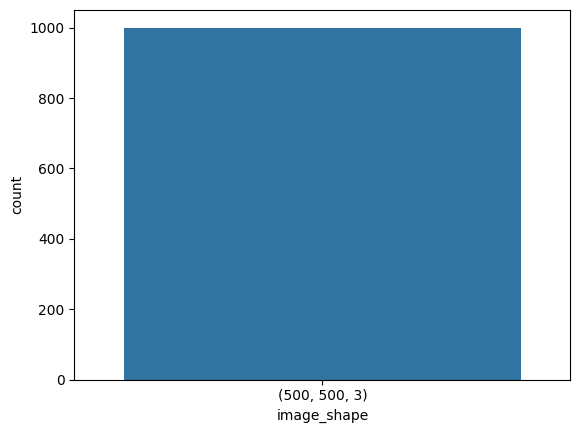

In [18]:
# Compter les occurrences des formats
sns.countplot(data=X_img_sample, x='image_shape', order=X_img_sample['image_shape'].value_counts().index)
plt.show()

On a bien uniquement des images en 500x500 pixels et en RGB.

### Content Box: la zone utile sans les bords blancs

Déterminons maintenant la "zone utile", c'est-à-dire l'image sans les bords blancs.

In [19]:
def get_content_box(image_path, seuil_ratio=0.99):
    """
    Détecte la bounding box du contenu non blanc d'une image.

    Args:
        image_path (str): chemin vers l'image.
        seuil (float): seuil pour considérer un pixel blanc (entre 0 et 1).
    Returns:
        tuple: dimensions de la zone utile (largeur, hauteur), coordonnées x_min, y_min, x_max, y_max.
    """
     
    # Charge l'image (forme: H x W x C), valeurs normalisées [0, 1]
    img = mpimg.imread(image_path)

    # img peut être chargé normalisé (valeurs de couleurs entre 0 et 1) ou en [0, 255]
    # On adapte donc le seuil en fonction de la valeur maximale des pixels
    seuil = seuil_ratio * img.max()

    # Crée un masque des pixels "non blancs"
    # Ici, on considère qu'un pixel est blanc si ses 3 canaux sont > seuil (proche de 1)
    non_white = np.any(img < seuil, axis=2)
   
    # Trouve les coordonnées de la zone utile
    coords = np.argwhere(non_white)

    if coords.size == 0:
        # "Image entièrement blanche."
        return None

    # Récupère les limites du contenu utile
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    width = x_max - x_min + 1
    height = y_max - y_min + 1

    # print(f"Taille utile : {width} x {height} pixels")
    # print(f"Bounding box : x={x_min}, y={y_min}, largeur={width}, hauteur={height}")

    return ((width, height), x_min, y_min, x_max, y_max)

Image dimensions: 500x500 pixels


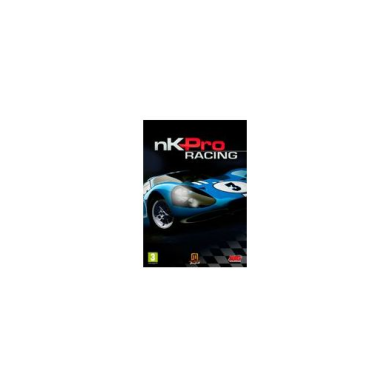

(146, 209) 175 144 320 352


In [22]:
# Exemple d’utilisation
display_image(X_img_sample.iloc[0]["image_path"], print_dim=True)
dim, x_min, y_min, x_max, y_max = get_content_box(image_path=X_img_sample.iloc[0]["image_path"])
print(dim, x_min, y_min, x_max, y_max)

In [23]:
# Charge l'image complète et retourne l'image utile à partir de la bounding box
def load_content_from_box(image_path, x_min, y_min, x_max, y_max):
    # Charge l'image complète
    img = mpimg.imread(image_path)

    # Attention : dans numpy, l'ordre est img[hauteur, largeur] donc img[y_min:y_max+1, x_min:x_max+1]
    img_cropped = img[y_min:y_max+1, x_min:x_max+1, :]
    return img_cropped


def load_content_box_from_image(image_path):
    """
    Charge l'image complète et retourne l'image utile.
    
    Args:
        image_path (str): chemin vers l'image.
    
    Returns:
        np.ndarray: image utile sans les bords blancs.
    """
    dim, x_min, y_min, x_max, y_max = get_content_box(image_path)
    if dim is None:
        return None  # Image entièrement blanche
    
    return load_content_from_box(image_path, x_min, y_min, x_max, y_max)

Image dimensions: 209x146 pixels


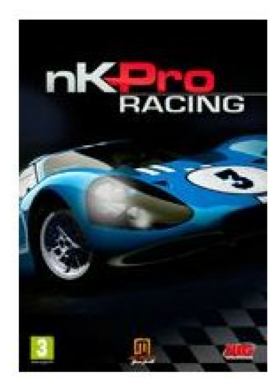

In [24]:
# Exemple d'utilisation
display_image(load_content_box_from_image(X_img_sample.iloc[0]["image_path"]), print_dim=True)

Remplissons notre Dataframe d'échantillon d'images avec ces informations.

In [25]:
df_content_box = X_img_sample["image_path"].apply(get_content_box).apply(pd.Series)
df_content_box.columns = ["content_dim", "x_min", "y_min", "x_max", "y_max"]

X_img_sample["content_dim"] = df_content_box["content_dim"]
X_img_sample[["content_width", "content_height"]] = X_img_sample["content_dim"].apply(pd.Series)
X_img_sample[["x_min", "y_min", "x_max", "y_max"]] = df_content_box[["x_min", "y_min", "x_max", "y_max"]]

In [26]:
data_info(X_img_sample)

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 36138 to 65534
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_path      1000 non-null   object
 1   image_shape     1000 non-null   object
 2   content_dim     1000 non-null   object
 3   content_width   1000 non-null   int64 
 4   content_height  1000 non-null   int64 
 5   x_min           1000 non-null   int64 
 6   y_min           1000 non-null   int64 
 7   x_max           1000 non-null   int64 
 8   y_max           1000 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 110.4+ KB




,image_path,image_shape,content_dim,content_width,content_height,x_min,y_min,x_max,y_max
36138,./../data/images/image_train/image_1100082580_...,"(500, 500, 3)","(146, 209)",146,209,175,144,320,352
68630,./../data/images/image_train/image_1139624392_...,"(500, 500, 3)","(194, 209)",194,209,175,144,368,352
36172,./../data/images/image_train/image_1271697301_...,"(500, 500, 3)","(500, 500)",500,500,0,0,499,499
9830,./../data/images/image_train/image_1313204688_...,"(500, 500, 3)","(395, 500)",395,500,53,0,447,499
28422,./../data/images/image_train/image_518749844_p...,"(500, 500, 3)","(368, 500)",368,500,64,0,431,499


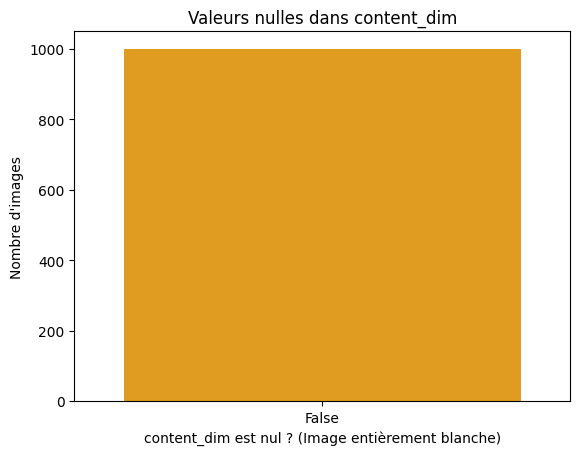

In [29]:
sns.barplot(
    x=X_img_sample["content_dim"].isnull().value_counts().index,
    y=X_img_sample["content_dim"].isnull().value_counts().values,
    palette={True: "blue", False: "orange"}
)
plt.title("Valeurs nulles dans content_dim")
plt.xlabel("content_dim est nul ? (Image entièrement blanche)")
plt.ylabel("Nombre d'images")
plt.show()

Quand une image est entièrement blanche, alors le content_dim est nul. Ce n'est pas le cas ici alors aucune de nos images (donc des images liées aux produits) n'est "nulle".

Il ne s'agit que d'un échantillon, même s'il a été choisi aléatoirement, cela ne nous donne pas la proportion totale, mais cela nous sert simplement d'idée. On supposera ainsi qu'aucune image n'est entièrement blanche.

### Uniformité des données d'image et préparation

On s'intéresse aux dimensions de la content box.

False    525
True     475
Name: count, dtype: int64


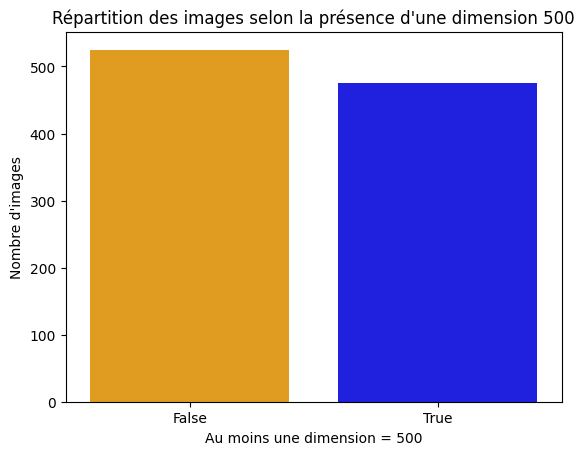

In [32]:
# On considère qu'une image est "complète" si au moins une de ses dimensions (largeur ou hauteur) est égale à 500 pixels.
# Création d'une colonne booléenne "image_complete" : True si width ou height = 500
image_complete = (X_img_sample['content_width'] == 500) | (X_img_sample['content_height'] == 500)
print(image_complete.value_counts())
# Countplot
sns.countplot(x=image_complete, palette={True: "blue", False: "orange"})

plt.xlabel("Au moins une dimension = 500")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images selon la présence d'une dimension 500")
plt.show()

On constate que 47,5% n'a aucune de ses dimensions égale à 500. Beaucoup d'images n'occupent donc pas l'espace disponible, dans aucune des dimensions: nous pourrions donc les étendre.

En effet, la zone utile (qui serait également la zone utile pour l'apprentissage par un modèle) est bien différente selon les images.
Nous pourrions alors nous intéresser à appliquer des algorithmes de Computer Vision pour combler cette différence et harmoniser les données et les vecteurs qui en résulteraient.
L'exemple le plus simple serait d'utiliser un filtre avec des masques pour agrandir les images jusqu'à atteindre un des bords.

Il serait plus difficile pour un modèle s'entraînant sur des images d'être pertinent si certaines données sont des matrices creuses (pleine de blanc) et d'autres sont pleines.

Par exemple, deux piscines prenant toute l'image auraient plus d'informations communes dans leurs pixels qu'une piscine en grand, et une piscine en toute petite (majorité de pixels blancs).

Nous aurions pu également visualiser l'ensemble des différents format de Content box mais cela serait bien trop éparpillé et le traitement final serait identique.

# Récapitulatif de l'analyse exploratoire des données initiales

|        | Nombre lignes dans la table : ? | 84916                                                                                                             | Pour le dataset utilisable                                                                                                                       |                                                                                                                      |            |                                                                                                                                                                                                                                           |                                                                                                                                                                                                      |                                                                                  |
|--------|---------------------------------|-------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| N° Col | Nom de la colonne               | Description                                                                                                       | Disponibilité de la variable a priori                                                                                                            | Type informatique                                                                                                    | Taux de NA | Gestion des NA                                                                                                                                                                                                                            | Distribution des valeurs                                                                                                                                                                             | Remarques sur la colonne                                                         |
|        |                                 | Que représente cette variable en quelques mots ?                                                                  | Pouvez vous connaitre ce champ en amont d'une prédiction ? Aurez vous accès à cette variable en environnement de production ?                    | int64, float etc...  Si "object", détaillez.                                                                         | en %       | Quelle mode de (non) - gestion des NA favorisez vous ?                                                                                                                                                                                    | Pour les variables catégorielles comportant moins de 10 catégories, énumérez toutes les catégories.  Pour les variables quantitatives, détaillez la distribution (statistiques descriptives de base) | champs libre à renseigner                                                        |
| 1      | Désignation                     | L’appelation du produit : comme une petite description qui donne l’essentiel sur le produit et donc sa catégorie. | Cette donnée est la base textuelle et est toujours accessible pour la prédiction même en environnement de production.                            | «object » qui est clairement une chaîne de caractères. Certains symboles doivent être changés pour la compréhension. | 0,00 %     | /                                                                                                                                                                                                                                         | C’est un string qui n’est ni quantitatif ni catégoriel. C’est une variable descriptive.                                                                                                              | Les valeurs d’un tel string sont très vastes et une analyse NLP sera nécessaire. |
| 2      | Description                     | Description plus détaillé du produit, de son état, de son utilisation. Regorge d’informations et de mots clés.    | Cette donnée est accessible pour la prédiction même en environnement de production, seulement quand elle n’est pas n/a (nombreuses occurrences). | «object » qui est clairement une chaîne de caractères. Certains symboles doivent être changés pour la compréhension. | 35.09%     | Il s’agit d’une description textuelle : on ne peut la générer pertinemment ni effectuer un remplissage statistique. Soit on l’utilise seulement lorsqu’elle est présente ; soit on fait un remplissage par IA à partir de la désignation. | Identique à la désignation à l’exception des nombreux N/A.                                                                                                                                           | Identique à la désignation.                                                      |
| 3      | productid                       | L’index du produit                                                                                                | N’aura pas de valeur pour être entraîné autre que pour relier le produit (textuel) à son image                                                   | int64                                                                                                                | 0,00 %     | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |
| 4      | imageid                         | L’index de l’image                                                                                                | N’aura pas de valeur pour être entraîné autre que pour relier le produit (textuel) à son image                                                   | int64                                                                                                                | 0,00 %     | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |
| 5      | imagepath                       | Le path de l’image pour l’associer au produit                                                                     | Utile en prod pour entraîner sur l’image tout en ayant la bonne évaluation de la classe                                                          | string                                                                                                               | 0.00%      | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |

# Stratégie envisagée suite à l'exploration des données

Première idée de stratégie:

- Diviser X_train en deux DataFrames : un pour l'entraînement, l'autre pour le test.
- Faire de même pour y_train avec la même répartition.
- Définir si nous décidons de remplir les descriptions nulles par des descriptions générées (identique à la désignation ? mot clé de la désignation ?) ou non.
- Créer un modèle pour classer les produits à partir du texte, incluant du traitement du langage naturel (NLP) sur la désignation et la description de chaque produit.
- Appliquer des algorithmes de Computer Vision pour harmoniser le dataset d'images.
- Transformer les images en vecteurs, associés aux produits, pour créer un DataFrame de pixels.
- Créer un modèle pour classer les produits à partir des images.
- Évaluer les deux modèles.
- Les ajuster ou les améliorer.
- Définir des pondérations pour les deux modèles en fonction de leurs performances.
- Créer une fonction pour obtenir une moyenne pondérée des probabilités pour les meilleures classes. (Comme pour du Bagging)
- Évaluer les résultats en sélectionnant la meilleure classe selon cette moyenne pondérée lors d'une phase de test.
- Tenter d'améliorer les résultats en travaillant sur les pondérations.
- Comparer les performances de ces résultats avec celles du meilleur des deux modèles initiaux.
- Conclure sur la solution (le modèle ou la combinaison) qui serait la plus efficace.